## <font color='cornflowerblue'> Packages

In [1]:
import ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## <font color='cornflowerblue'> Classes and Functions

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [3]:
class TradingMetrics:
    def __init__(self, portfolio_values: list[float], time_frame: int):
        self.portfolio_values = portfolio_values
        self.time_frame = time_frame  # in minutes

        self.df = pd.DataFrame({
            'value': self.portfolio_values,
            'rets': pd.Series(self.portfolio_values).pct_change()
        }).dropna()

    def sharpe_ratio(self) -> float:
        mean = self.df.rets.mean()
        std = self.df.rets.std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_std = std * np.sqrt(bars_per_year)
        
        return annual_mean / annual_std

    def sortino_ratio(self) -> float:
        mean = self.df.rets.mean()
        downside_risk = np.minimum(self.df.rets, 0).std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_downside_risk = downside_risk * np.sqrt(bars_per_year)

        return annual_mean / annual_downside_risk

    def max_drawdown(self) -> float:
        roll_max = self.df.value.cummax()
        drawdown = (roll_max - self.df.value) / roll_max  # Drawdown as positive values
        return drawdown.max()  # Maximum drawdown as positive percentage

    def calmar_ratio(self) -> float:
        mean = self.df.rets.mean()
        
        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        
        max_dd = self.max_drawdown()  # Now this returns a positive value
        
        return annual_mean / max_dd if max_dd != 0 else 0

    def show_metrics(self) -> pd.DataFrame:
        df = pd.DataFrame(
            {
                'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'],
                'Value': [self.sharpe_ratio(), self.sortino_ratio(), f'{self.max_drawdown():.2%}', self.calmar_ratio()]
            }
        )
        return df

In [4]:
def rsi(data: pd.DataFrame, window: int, rsi_lower: int, rsi_upper: int) -> pd.DataFrame:
    df = data.copy()
    rsi_indicator = ta.momentum.RSIIndicator(df.Close, window=window)
    df['rsi'] = rsi_indicator.rsi()
    df['buy_signal'] = df['rsi'] < rsi_lower
    df['sell_signal'] = df['rsi'] > rsi_upper
    df = df.dropna()
    return df

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        (pos.price - current_price) * pos.n_shares * (1 - COM)
        for pos in short_ops
    )

    return val + short_val

## <font color='cornflowerblue'> Data

In [6]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

In [7]:
data = rsi(data, window=25, rsi_lower=32, rsi_upper=72)
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
24,24,1609777800,0,2021-01-04 16:30:00,129.889892,130.089996,129.619995,129.910003,1379536.0,31.181021,True,False
25,25,1609778100,0,2021-01-04 16:35:00,129.914794,129.929992,129.600006,129.690002,1060015.0,29.621070,True,False
26,26,1609778400,0,2021-01-04 16:40:00,129.679992,129.679992,129.270004,129.390106,1729037.0,27.656393,True,False
27,27,1609778700,0,2021-01-04 16:45:00,129.399993,129.585006,129.329299,129.413299,1180904.0,28.040889,True,False
28,28,1609779000,0,2021-01-04 16:50:00,129.410003,129.529998,129.110000,129.148498,1457144.0,26.373813,True,False


## <font color='cornflowerblue'> Parameters

In [8]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.1449606732271905
TAKE_PROFIT: float = 0.07216372458077823
N_SHARES: int = 478

## <font color='cornflowerblue'> Backtest

In [16]:
capital: float = 1_000_000

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # Checkin nonnegative portfolio value
    if portfolio_value[-1] < 0:
        print("Portfolio value went negative. Stopping backtest.")
        portfolio_value.extend([0] * (len(data)+1-len(portfolio_value)))
        break
    
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    # -- SHORT -- #
    # Check active orders
    for position in active_short_positions.copy():
        # Stop loss or take profit check
        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl
            # Remove position from active position
            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        commission = row.Close * N_SHARES * COM
        # Do we have enough cash?
        if capital > commission:
            # Discount commission
            capital -= commission
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                            time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM))

# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl

active_long_positions = []
active_short_positions = []

Portfolio value went negative. Stopping backtest.


In [17]:
capital

7181.875455911134

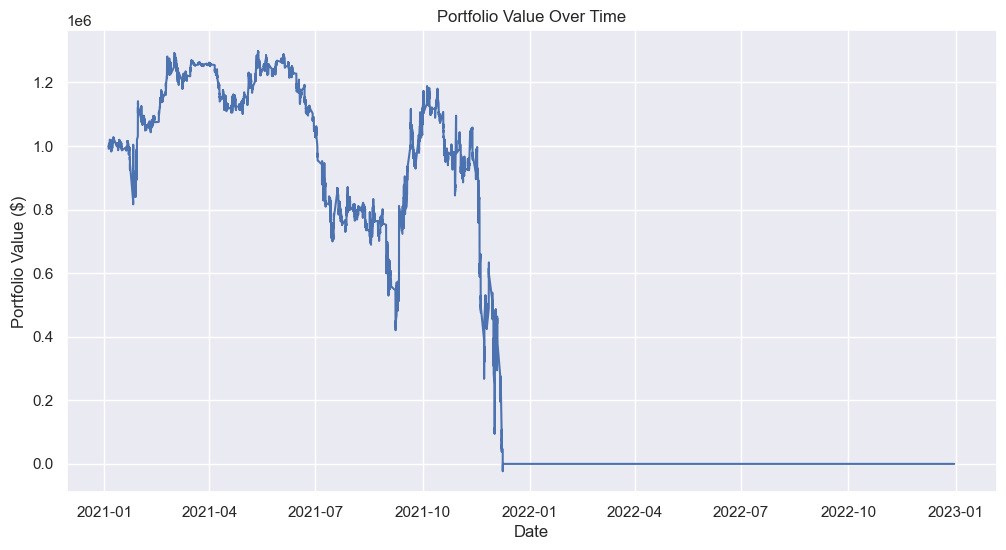

In [18]:
df = pd.DataFrame({'Portfolio Value': portfolio_value[1:]},
                  index=pd.to_datetime(data.Datetime))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()

## <font color='cornflowerblue'> Metrics

In [19]:
metrics = TradingMetrics(portfolio_value, time_frame=5)
metrics.show_metrics()

,Metric,Value
0,Sharpe Ratio,-1.522323
1,Sortino Ratio,-1.576632
2,Max Drawdown,101.78%
3,Calmar Ratio,-9.033067
